In [1]:
import sys
sys.path.insert(0, '../../..')
from cgi import test
from multiprocessing.sharedctypes import Value
from yaml import parse
import glob
import warnings
import requests
import dateutil
import pytz
import traceback
import pandas            as pd
import pandas_ta         as ta
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mlfinlab          as fml
from   mlfinlab          import sample_weights
import pyfolio           as pf
from scipy.stats         import norm
from backtesting         import Backtest, Strategy
from backtesting.lib     import crossover

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,12)

/home/sharav/src/alpha-discovery-workflow/env/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# loading history with features...
print("reading dataset...")

df = pd.read_csv("/home/sharav/src/project-feature-generation/data/features_BTCUSDT-1m-spot.csv", parse_dates=True, index_col="timestamp")

df

reading dataset...


,Open,High,Low,Close,Volume,m_rsi,m_roc,m_wr,vm_cmf,vm_mfi,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-18 04:04:00,4269.26,4269.26,4269.26,4269.26,0.988305,38.387955,-0.440284,-99.185249,0.636822,42.520834,...,-0.999636,-0.687760,0,1.146701,0.880253,16.873143,-13.129643,19.905429,-0.233253,9.252000
2017-08-18 04:05:00,4269.01,4269.01,4269.01,4269.01,0.557007,38.236424,-0.446114,-100.000000,0.626582,40.226107,...,-0.779648,-0.108492,0,1.000000,0.863521,12.400286,-36.856195,22.145429,-0.749626,11.392851
2017-08-18 04:07:00,4269.01,4269.01,4269.01,4269.01,0.591960,38.236424,-0.446346,-100.000000,0.682004,40.226107,...,-0.652191,0.074857,0,1.000000,0.808468,4.594286,-56.833464,24.485714,-1.530110,9.327503
2017-08-18 04:08:00,4269.01,4269.01,4269.01,4269.01,0.339186,38.236424,-0.446346,-100.000000,0.650170,37.361274,...,-0.694225,0.018055,0,1.000000,0.758373,1.512571,-60.862617,24.833143,-1.793890,0.100000
2017-08-18 04:09:00,4269.01,4269.01,4269.01,4269.01,0.320267,38.236424,-0.446346,-100.000000,0.550699,37.361274,...,-0.603405,0.137199,0,1.000000,0.773224,-1.022286,-63.128481,24.633714,-1.973538,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 23:55:00,17175.50,17215.59,17170.01,17173.33,531.365170,46.137493,-0.114233,-94.197833,0.083025,62.619445,...,-0.906090,-0.939869,1,-0.009388,0.938741,10.803714,-61.993322,35.246286,-1.880198,11.653086
2022-11-30 23:56:00,17173.33,17175.40,17150.70,17167.16,322.428780,43.956738,-0.319124,-78.492095,0.073701,56.234268,...,-0.987122,-0.811116,0,0.326073,0.938331,8.844286,-70.714762,45.997143,-2.857912,11.572630
2022-11-30 23:57:00,17165.50,17170.80,17156.77,17161.26,160.506230,41.916461,-0.303599,-86.201490,0.074486,51.053431,...,-0.989422,-0.597048,0,0.324145,0.939648,5.946000,-75.486770,56.165429,-3.863033,12.204749


In [3]:
# Helper functions


from pathlib import PurePath, Path
import sys
import time
import warnings
import datetime as dt
import multiprocessing as mp
from datetime import datetime
from collections import OrderedDict as od
import re
import os
import json
import pandas as pd
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
import mplfinance as mpf

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')


class MultiProcessingFunctions:
	""" This static functions in this class enable multi-processing"""
	def __init__(self):
		pass

	@staticmethod
	def lin_parts(num_atoms, num_threads):
		""" This function partitions a list of atoms in subsets (molecules) of equal size.
		An atom is a set of indivisible set of tasks.
		"""

		# partition of atoms with a single loop
		parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
		parts = np.ceil(parts).astype(int)
		return parts

	@staticmethod
	def nested_parts(num_atoms, num_threads, upper_triangle=False):
		""" This function enables parallelization of nested loops.
		"""
		# partition of atoms with an inner loop
		parts = []
		num_threads_ = min(num_threads, num_atoms)

		for num in range(num_threads_):
			part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
			part = (-1 + part ** .5) / 2.
			parts.append(part)

		parts = np.round(parts).astype(int)

		if upper_triangle:  # the first rows are heaviest
			parts = np.cumsum(np.diff(parts)[::-1])
			parts = np.append(np.array([0]), parts)
		return parts

	@staticmethod
	def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
		"""	
		:param func: (string) function to be parallelized
		:param pd_obj: (vector) Element 0, is name of argument used to pass the molecule;
						Element 1, is the list of atoms to be grouped into a molecule
		:param num_threads: (int) number of threads
		:param mp_batches: (int) number of batches
		:param lin_mols: (bool) Tells if the method should use linear or nested partitioning
		:param kargs: (var args)
		:return: (data frame) of results
		"""

		if lin_mols:
			parts = MultiProcessingFunctions.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
		else:
			parts = MultiProcessingFunctions.nested_parts(len(pd_obj[1]), num_threads * mp_batches)

		jobs = []
		for i in range(1, len(parts)):
			job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
			job.update(kargs)
			jobs.append(job)

		if num_threads == 1:
			out = MultiProcessingFunctions.process_jobs_(jobs)
		else:
			out = MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)

		if isinstance(out[0], pd.DataFrame):
			df0 = pd.DataFrame()
		elif isinstance(out[0], pd.Series):
			df0 = pd.Series()
		else:
			return out

		for i in out:
			df0 = df0.append(i)

		df0 = df0.sort_index()
		return df0

	@staticmethod
	def process_jobs_(jobs):
		""" Run jobs sequentially, for debugging """
		out = []
		for job in jobs:
			out_ = MultiProcessingFunctions.expand_call(job)
			out.append(out_)
		return out

	@staticmethod
	def expand_call(kargs):
		""" Expand the arguments of a callback function, kargs['func'] """
		func = kargs['func']
		del kargs['func']
		out = func(**kargs)
		return out

	@staticmethod
	def report_progress(job_num, num_jobs, time0, task):
		# Report progress as asynch jobs are completed

		msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
		msg.append(msg[1] * (1/msg[0] - 1))
		time_stamp = str(dt.datetime.fromtimestamp(time.time()))

		msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
			str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

		if job_num < num_jobs:
			sys.stderr.write(msg+'\r')
		else:
			sys.stderr.write(msg+'\n')

		return

	@staticmethod
	def process_jobs(jobs, task=None, num_threads=24):
		""" Run in parallel. jobs must contain a 'func' callback, for expand_call"""

		if task is None:
			task = jobs[0]['func'].__name__

		pool = mp.Pool(processes=num_threads)
		# outputs, out, time0 = pool.imap_unordered(MultiProcessingFunctions.expand_call,jobs),[],time.time()
		outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
		out = []
		time0 = time.time()

		# Process asyn output, report progress
		for i, out_ in enumerate(outputs, 1):
			out.append(out_)
			MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

		pool.close()
		pool.join()  # this is needed to prevent memory leaks
		return out


def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0


def get_t_events(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps


def add_vertical_barrier(t_events, close, num_days=1):
    """
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) maximum number of days a trade can be active
    :return: (series) timestamps of vertical barriers
    """
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    return t1


def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param close: (series) close prices
    :param events: (series) of indices that signify "events" 
    :param pt_sl: (array) element 0, indicates the profit taking level; 
                          element 1 is stop loss level
    :param molecule: (an array) a set of datetime index values for processing
    :return: (dataframe) timestamps at which each barrier was touched
    """
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs

    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out


def get_events(close, t_events, pt_sl, target, min_ret, num_threads, 
              vertical_barrier_times=False, side=None):
    """
    :param close: (series) Close prices
    :param t_events: (series) of t_events. 
                     These are timestamps that will seed every triple barrier.
    :param pt_sl: (2 element array) element 0, indicates the profit taking level; 
                  element 1 is stop loss level.
                  A non-negative float that sets the width of the two barriers. 
                  A 0 value means that the respective horizontal barrier will be disabled.
    :param target: (series) of values that are used (in conjunction with pt_sl)
                   to determine the width of the barrier.
    :param min_ret: (float) The minimum target return required for running a triple barrier search.
    :param num_threads: (int) The number of threads concurrently used by the function.
    :param vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.
    :param side: (series) Side of the bet (long/short) as decided by the primary model
    :return: (data frame) of events
            -events.index is event's starttime
            -events['t1'] is event's endtime
            -events['trgt'] is event's target
            -events['side'] (optional) implies the algo's position side
    """

    # 1) Get target
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])

    # Apply Triple Barrier
    df0 = MultiProcessingFunctions.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

    if side is None:
        events = events.drop('side', axis=1)

    return events


def barrier_touched(out_df):
    """
    :param out_df: (DataFrame) containing the returns and target
    :return: (DataFrame) containing returns, target, and labels
    """
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret       = out_df.loc[date_time, 'ret' ]
        target    = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store

    return out_df


def get_bins(triple_barrier_events, close):
    """
    :param triple_barrier_events: (data frame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (series) close prices
    :return: (data frame) of meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret' ] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
        
    out_df

    return out_df



def get_daily_volatility(close, lookback=100):
    # daily vol re-indexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
    df0 = close.loc[df0.index] / close.loc[df0.array].array - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

def cci_indicator(df_, length=40):
    hlc3 = (df_['High']+df_['Low']+df_['Close'])/3
    sma  = hlc3.rolling(length).mean()
    mad  = hlc3.rolling(length).apply(lambda x: pd.Series(x).mad())
    cci  = (hlc3-sma)/(0.015*mad)
    cci_smooth = cci.ewm(span=5, min_periods=0, adjust=False, ignore_na=False).mean()
    return cci, cci_smooth

In [4]:
# CCI signal extraction

timeframe = 5

d = {
    'Open'  : 'first', 
    'High'  : 'max'  ,
    'Low'   : 'min'  ,
    'Close' : 'last' ,
    'Volume': 'sum'
    }
df_xm = df.resample(f"{timeframe}Min").agg(d)

df_xm['cci'], _ = cci_indicator(df_xm)
df_xm.dropna(inplace=True)

sigma : -232.58113644364732 232.58113644364732


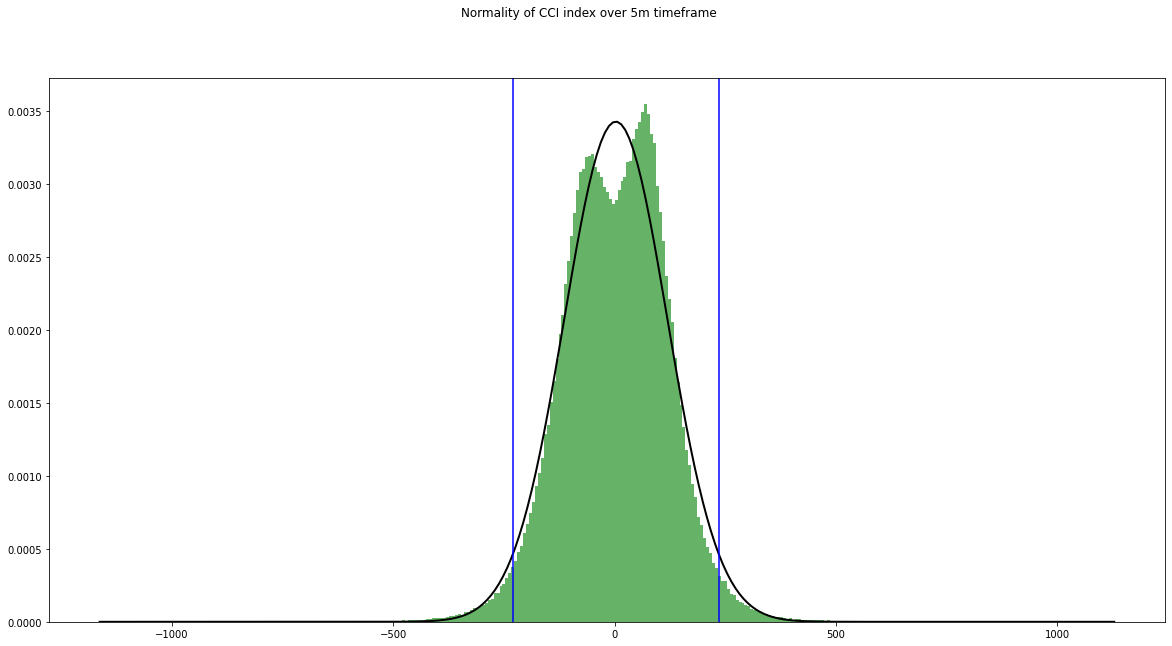

In [5]:
# calculate normal distribution of CCI indicator
sigma_f = 2.0

fig, axs = plt.subplots(1, figsize=(20, 10))
fig.suptitle(f"Normality of CCI index over {timeframe}m timeframe")

xmin = df_xm['cci'].values.min()
xmax = df_xm['cci'].values.max()
bins =  250

mu, sigma = norm.fit(df_xm['cci'].values)

x = np.linspace(xmin, xmax, bins)
p = norm.pdf(x, mu, sigma)
axs.hist(df_xm['cci'].values, bins=150, density=True, alpha=0.6, color='g', range=(-500, 500))

axs.plot(x, p, 'k', linewidth=2)

axs.axvline(x=mu-sigma_f*sigma, color='b')
axs.axvline(x=mu+sigma_f*sigma, color='b')

print(f"sigma : {-sigma_f*sigma} {sigma_f*sigma}")

In [6]:
upper_threshold =  233
lower_threshold = -233

df_xm['position'] = 0
df_xm.loc[(df_xm['cci'].shift(1)<upper_threshold)&(df_xm['cci']>=upper_threshold), 'position'] = -1
df_xm.loc[(df_xm['cci'].shift(1)>lower_threshold)&(df_xm['cci']<=lower_threshold), 'position'] =  1

# saving signals to market state
df['position'] = 0
for idx, row in df_xm[(df_xm['position']==1)|(df_xm['position']==-1)].iterrows():
    if idx in df.index:
        df.loc[idx, 'position'] = row.position

# removing look-ahead bias by lagging signal
df['position'] = df['position'].shift(timeframe+1)

df.dropna(inplace=True)

In [7]:
df['position'].value_counts()

 0.0    2734893
 1.0       4231
-1.0       3852
Name: position, dtype: int64

In [8]:
# Daily volatility calculation which is helpful for defining tp and sl levels

w = 840 # 14 hours
df['volatility_tpsl'] = get_daily_volatility(close=df['Close'], lookback=w)

In [9]:
signals_index = df[(df['position']==1)|(df['position']==-1)].index
signals_index

DatetimeIndex(['2017-08-22 09:43:00', '2017-08-22 12:36:00',
               '2017-08-22 13:01:00', '2017-08-24 12:31:00',
               '2017-08-25 03:17:00', '2017-09-02 14:41:00',
               '2017-09-03 13:50:00', '2017-09-04 18:47:00',
               '2017-09-04 19:04:00', '2017-09-05 02:01:00',
               ...
               '2022-11-29 04:31:00', '2022-11-29 13:41:00',
               '2022-11-29 13:56:00', '2022-11-29 19:06:00',
               '2022-11-30 00:41:00', '2022-11-30 12:41:00',
               '2022-11-30 12:56:00', '2022-11-30 17:26:00',
               '2022-11-30 19:21:00', '2022-11-30 23:01:00'],
              dtype='datetime64[ns]', name='timestamp', length=8083, freq=None)

In [10]:
vertical_barriers = add_vertical_barrier(t_events=signals_index, close=df['Close'], num_days=2)
vertical_barriers

timestamp
2017-08-22 09:43:00   2017-08-24 09:43:00
2017-08-22 12:36:00   2017-08-24 12:36:00
2017-08-22 13:01:00   2017-08-24 13:01:00
2017-08-24 12:31:00   2017-08-26 12:34:00
2017-08-25 03:17:00   2017-08-27 03:30:00
                              ...        
2022-11-28 01:26:00   2022-11-30 01:26:00
2022-11-28 12:51:00   2022-11-30 12:51:00
2022-11-28 14:41:00   2022-11-30 14:41:00
2022-11-28 16:11:00   2022-11-30 16:11:00
2022-11-28 17:06:00   2022-11-30 17:06:00
Name: timestamp, Length: 8072, dtype: datetime64[ns]

In [11]:
# TBL labeling training set 

RR         = 2.0
sl_target  = 1.2

min_ret    = 0.001 # minimum return of 0.1%

long_ptsl  = [round(sl_target*RR, 2), sl_target]
short_ptsl = [round(sl_target*RR, 2), sl_target]

print(f"{RR} -> {long_ptsl}")


long_triple_barrier_events = get_events( 
                                    close                  = df['Close'],
                                    t_events               = df[df['position']==1].index,
                                    pt_sl                  = long_ptsl,
                                    target                 = df['volatility_tpsl'],
                                    min_ret                = min_ret,
                                    num_threads            = 8,
                                    vertical_barrier_times = vertical_barriers,
                                    side                   = df[df['position']==1]['position']
                                    )

short_triple_barrier_events = get_events( 
                                    close                  = df['Close'],
                                    t_events               = df[df['position']==-1].index,
                                    pt_sl                  = short_ptsl,
                                    target                 = df['volatility_tpsl'],
                                    min_ret                = min_ret,
                                    num_threads            = 8,
                                    vertical_barrier_times = vertical_barriers,
                                    side                   = df[df['position']==-1]['position']
                                    )

triple_barrier_events = pd.concat([long_triple_barrier_events, short_triple_barrier_events])
triple_barrier_events = triple_barrier_events.sort_index()
triple_barrier_events.dropna(inplace=True)


labels = get_bins(triple_barrier_events, df['Close'])
labels.dropna(inplace=True)

labels = labels.sort_index()
labels = labels[~labels.index.duplicated(keep='last')]

labels['bin'].value_counts()

2.0 -> [2.4, 1.2]


2022-12-23 10:19:35.732404 100.0% apply_pt_sl_on_t1 done after 0.09 minutes. Remaining 0.0 minutes.
2022-12-23 10:19:38.072532 100.0% apply_pt_sl_on_t1 done after 0.03 minutes. Remaining 0.0 minutes.


0    5687
1    2394
Name: bin, dtype: int64

In [12]:
from mlfinlab.sample_weights import get_weights_by_return, get_weights_by_time_decay

return_based_sample_weights = get_weights_by_return(triple_barrier_events, df.loc[triple_barrier_events.index, 'Close'], num_threads=1)
return_based_sample_weights

2017-08-22 09:43:00    0.461515
2017-08-22 12:36:00    0.461515
2017-08-22 13:01:00    0.530852
2017-08-24 12:31:00    8.439390
2017-08-25 03:17:00    2.471120
                         ...   
2022-11-29 19:06:00    0.044458
2022-11-30 00:41:00    0.694012
2022-11-30 12:41:00    0.828890
2022-11-30 12:56:00    0.300312
2022-11-30 17:26:00    0.243410
Length: 8081, dtype: float64

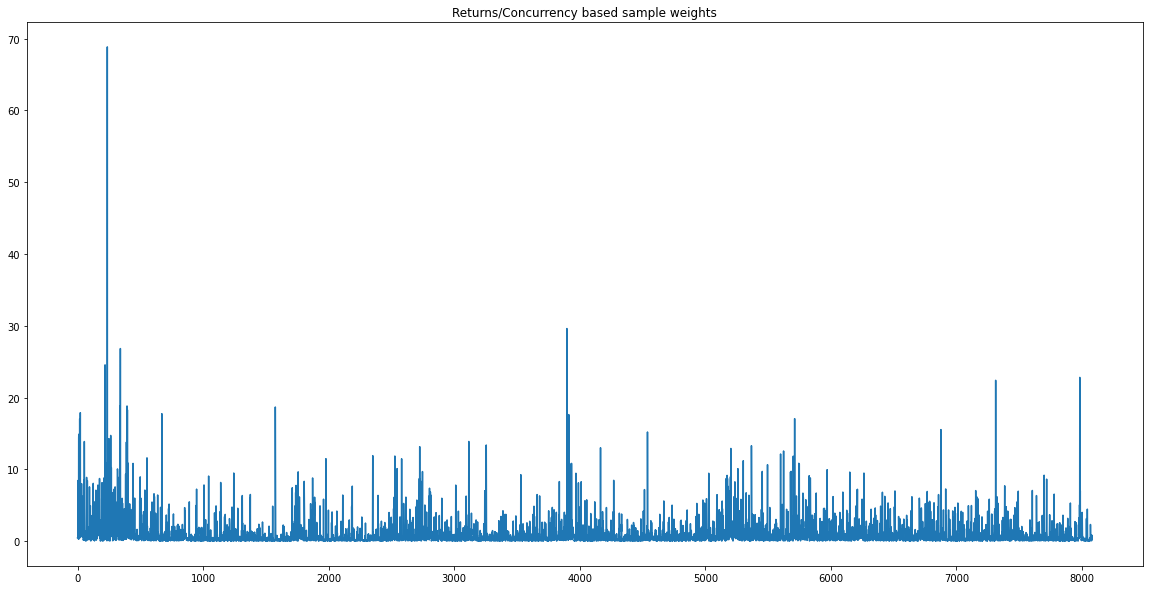

In [13]:
plt.figure(figsize=(20, 10))
plt.title('Returns/Concurrency based sample weights')
return_based_sample_weights.reset_index()[0].plot()
plt.show()

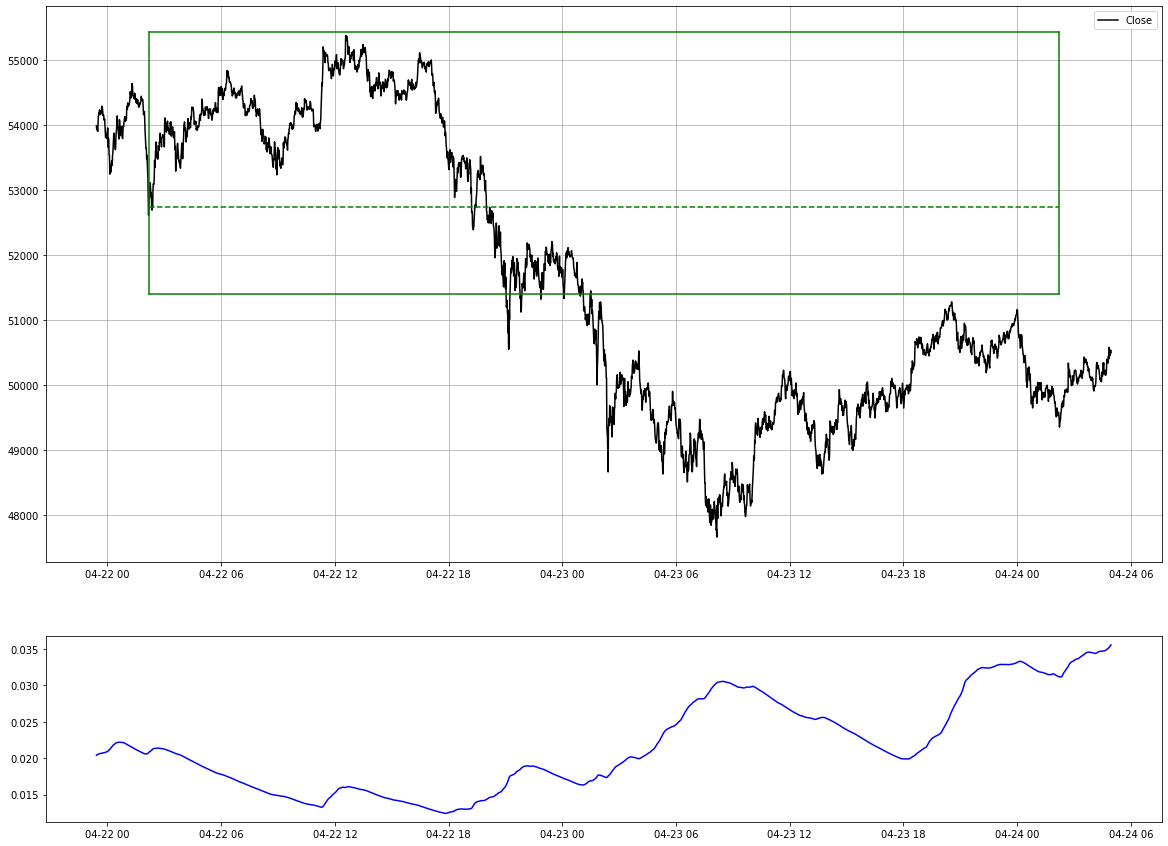

In [14]:
# Plotting buy side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = labels[(labels['bin']==1)&(labels['side']==1)].sample()
selected_date = label.index[0]

duration_seconds = 172800  # 2 days

frame_start   = selected_date - pd.Timedelta(seconds=10000) 
frame_end     = selected_date + pd.Timedelta(seconds=duration_seconds+10000)

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = selected_date
event_end   = selected_date+pd.Timedelta(seconds=duration_seconds)

close_price = df.loc[df.index==selected_date]['Close'].values[-1]

volatility_tpsl = round(df['volatility_tpsl'][selected_date], 6)

ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0

price_upper = (ret_upper+1.0)*close_price
price_lower = (ret_lower+1.0)*close_price

delta_upper = abs(close_price-price_upper)
delta_lower = abs(close_price-price_lower)

price_tp = close_price+delta_upper
price_sl = close_price-delta_lower


df_plot = df_

axs[0].plot(df_plot['Close'], color='k', label='Close')
axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_tp    , price_tp  ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [price_sl    , price_sl  ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='g')
axs[0].plot([event_start, event_start], [price_sl    , price_tp  ], 'r-' , color='g')
axs[0].plot([event_end  , event_end  ], [price_sl    , price_tp  ], 'r-' , color='g')

axs[1].plot(df_plot['volatility_tpsl'], color='b', label="daily volatility")

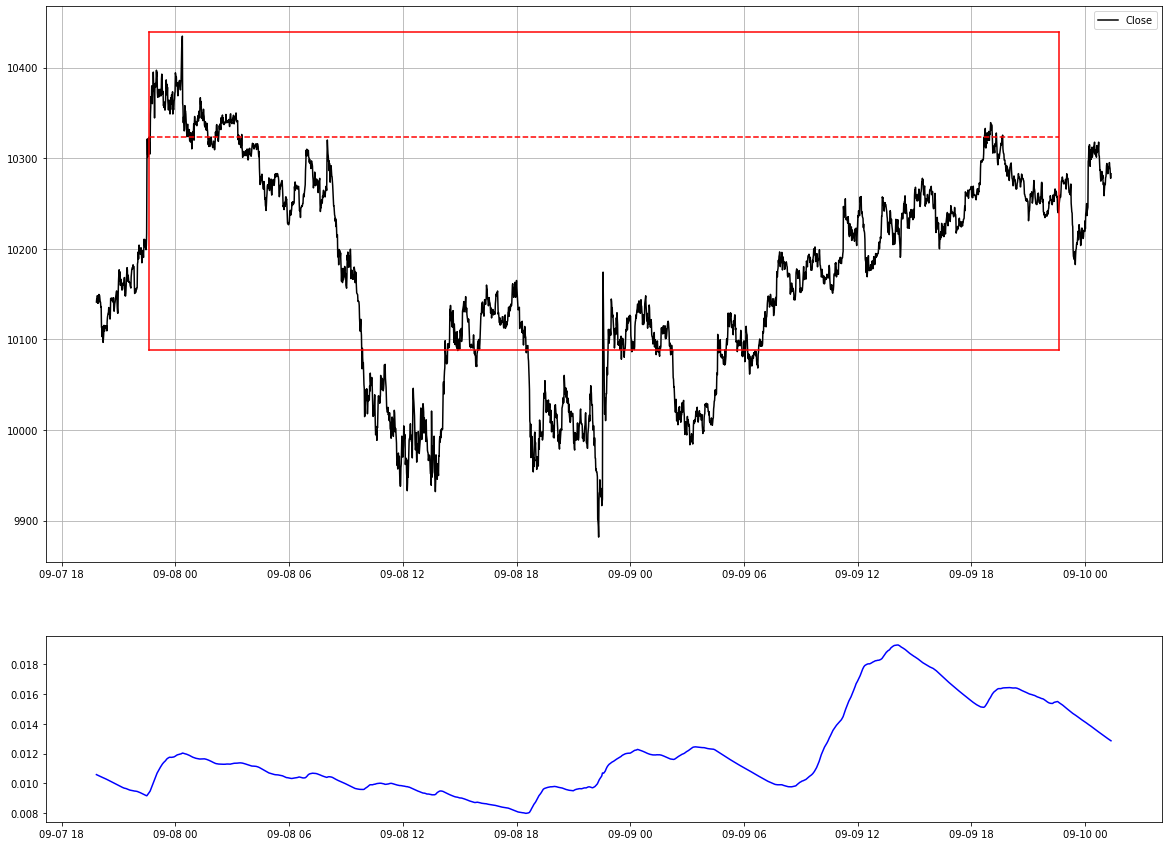

In [15]:
# Plotting sell side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = labels[(labels['bin']==1)&(labels['side']==-1)].sample()
selected_date = label.index[0]

duration_seconds = 172800 # 2 days

frame_start   = selected_date - pd.Timedelta(seconds=10000) 
frame_end     = selected_date + pd.Timedelta(seconds=duration_seconds+10000)

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = selected_date
event_end   = selected_date+pd.Timedelta(seconds=duration_seconds)

close_price = df.loc[df.index==selected_date]['Close'].values[-1]

volatility_tpsl = round(df['volatility_tpsl'][selected_date], 6)

ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0

price_upper = (ret_upper+1.0)*close_price
price_lower = (ret_lower+1.0)*close_price

delta_upper = abs(close_price-price_upper)
delta_lower = abs(close_price-price_lower)

price_sl = close_price+delta_upper
price_tp = close_price-delta_lower


df_plot = df_

axs[0].plot(df_plot['Close'], color='k', label='Close')
axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_tp    , price_tp  ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [price_sl    , price_sl  ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='r')
axs[0].plot([event_start, event_start], [price_sl    , price_tp  ], 'r-' , color='r')
axs[0].plot([event_end  , event_end  ], [price_sl    , price_tp  ], 'r-' , color='r')

axs[1].plot(df_plot['volatility_tpsl'], color='b', label="daily volatility")

In [16]:
# Model performance evaluation on OOS data
from backtesting     import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import resample_apply

def SMA(array, n):
    return pd.Series(array).rolling(n).mean()


binance_commission = 0.0004  # Taker Fee rate is 0.04%

In [17]:
class CCIRawLongStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==1:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=1.0, sl=price_sl, tp=price_tp)

bt = Backtest(
    df, #df["2020-01-05":], 
    CCIRawLongStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2017-08-18 04:12:00
End                       2022-11-30 23:59:00
Duration                   1930 days 19:47:00
Exposure Time [%]                   71.852251
Equity Final [$]              99971176.056887
Equity Peak [$]              100037616.576325
Return [%]                          -0.028824
Buy & Hold Return [%]               302.28287
Return (Ann.) [%]                   -0.005449
Volatility (Ann.) [%]                0.016246
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.067547
Avg. Drawdown [%]                   -0.000415
Max. Drawdown Duration     1113 days 06:47:00
Avg. Drawdown Duration        3 days 06:18:00
# Trades                                 1212
Win Rate [%]                        32.838284
Best Trade [%]                      29.490409
Worst Trade [%]                    -13.822712
Avg. Trade [%]                    

Start date,2017-08-24
End date,2022-11-30
Total months,57
,Backtest
Annual return,-18.5%
Cumulative returns,-62.7%
Annual volatility,66.6%
Sharpe ratio,0.01
Calmar ratio,-0.22
Stability,0.56
Max drawdown,-83.4%


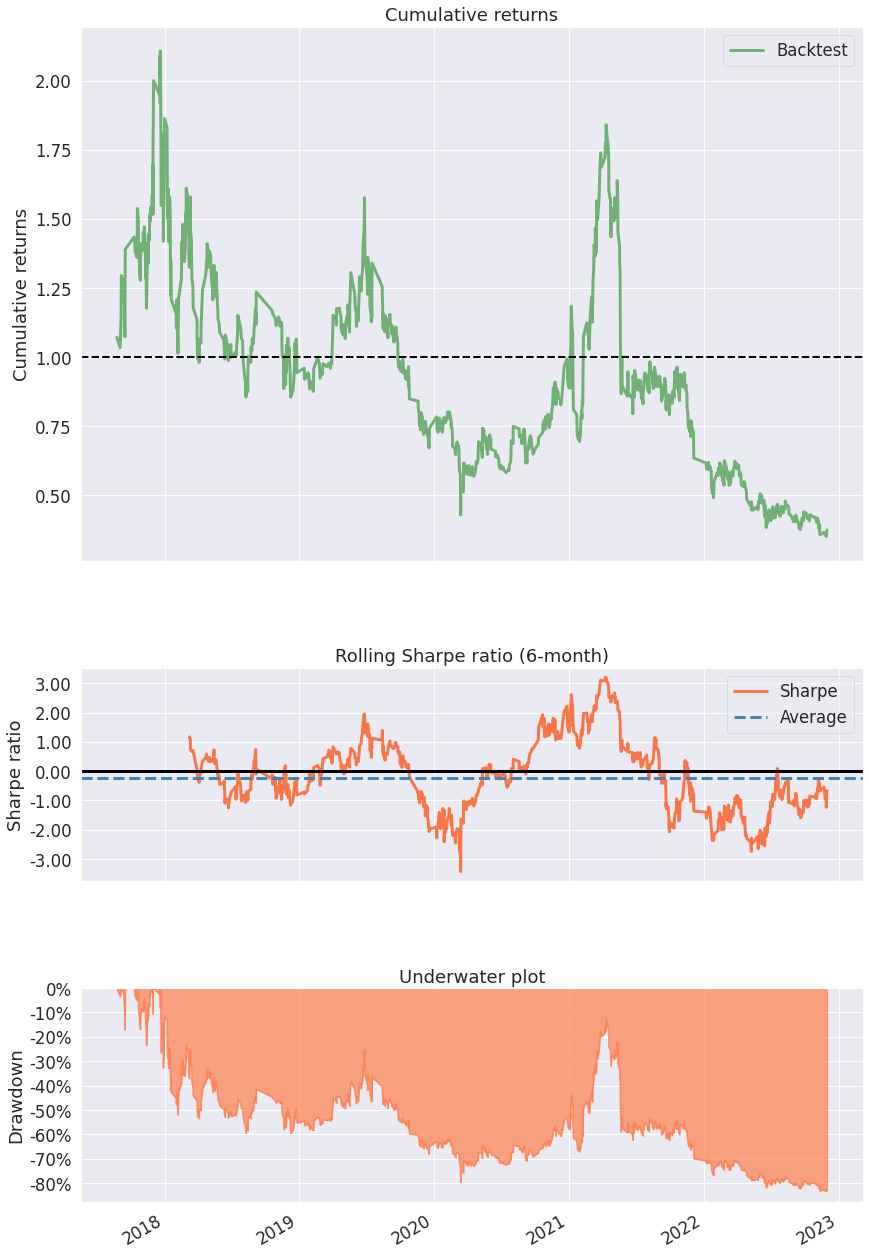

In [18]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [19]:
class CCIRawLongFilteredStrategy(Strategy):
    def init(self):
        super().init()
        self.sma_fast = resample_apply('30Min', SMA, self.data.Close, 50 )
        self.sma_slow = resample_apply('30Min', SMA, self.data.Close, 200)

    def next(self):
        super().next()

        is_up_trend   = False
        if self.sma_fast[-1]>self.sma_slow[-1]:
            is_up_trend = True

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==1 and is_up_trend:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=1.0, sl=price_sl, tp=price_tp)

bt = Backtest(
    df, #df["2020-01-05":], 
    CCIRawLongFilteredStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2017-08-18 04:12:00
End                       2022-11-30 23:59:00
Duration                   1930 days 19:47:00
Exposure Time [%]                   46.146084
Equity Final [$]              99990716.980357
Equity Peak [$]              100031063.212864
Return [%]                          -0.009283
Buy & Hold Return [%]               302.28287
Return (Ann.) [%]                   -0.001755
Volatility (Ann.) [%]                0.011243
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.042638
Avg. Drawdown [%]                   -0.000445
Max. Drawdown Duration     1102 days 20:21:00
Avg. Drawdown Duration        4 days 14:12:00
# Trades                                  758
Win Rate [%]                         32.98153
Best Trade [%]                      20.483855
Worst Trade [%]                    -12.147424
Avg. Trade [%]                    

Start date,2017-08-24
End date,2022-11-30
Total months,36
,Backtest
Annual return,2.2%
Cumulative returns,6.6%
Annual volatility,61.0%
Sharpe ratio,0.33
Calmar ratio,0.04
Stability,0.12
Max drawdown,-59.4%


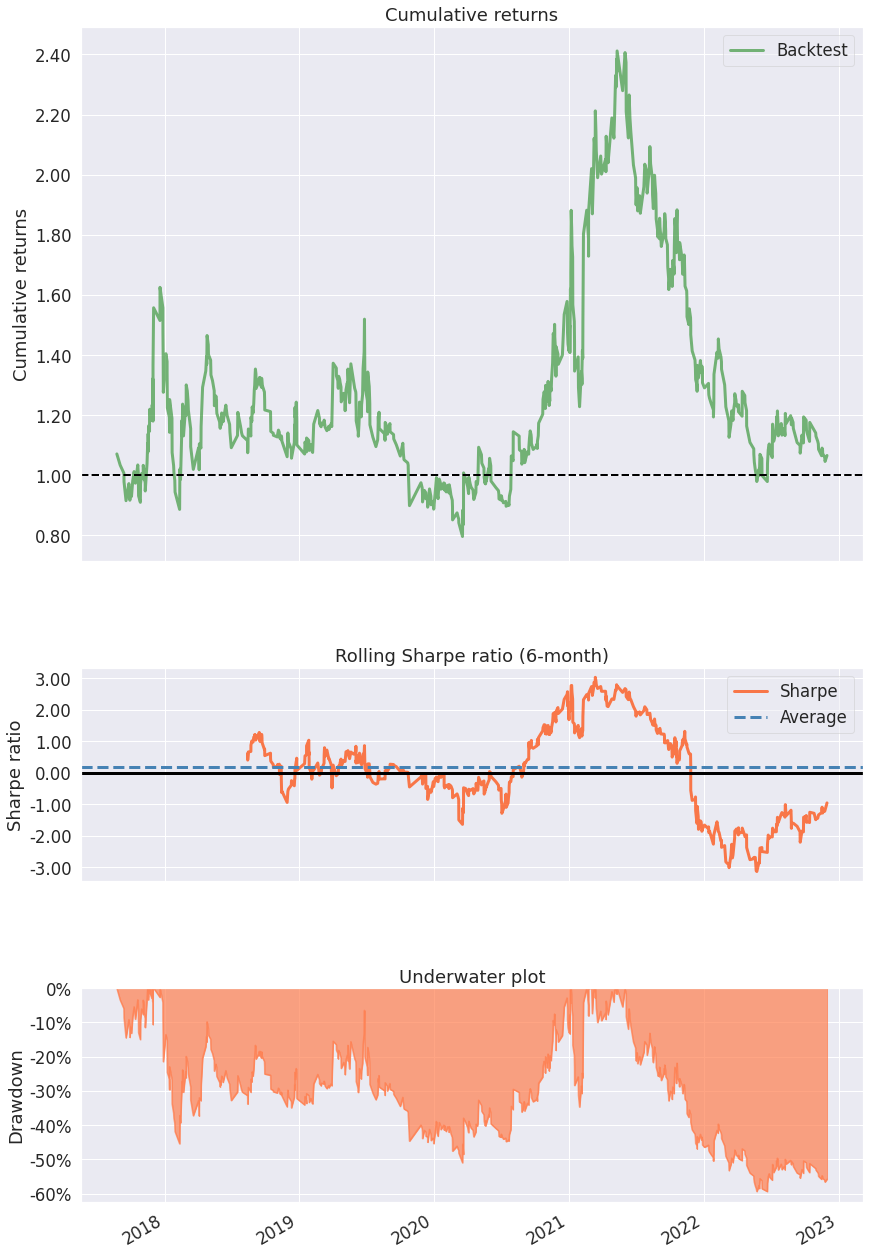

In [20]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [22]:
class CCIRawShortStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==-1:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=1.0, sl=price_sl, tp=price_tp)
    

bt = Backtest(
    df, #df["2020-01-05":], 
    CCIRawShortStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2017-08-18 04:12:00
End                       2022-11-30 23:59:00
Duration                   1930 days 19:47:00
Exposure Time [%]                   70.485123
Equity Final [$]             100028039.539739
Equity Peak [$]              100030557.155388
Return [%]                            0.02804
Buy & Hold Return [%]               302.28287
Return (Ann.) [%]                    0.005299
Volatility (Ann.) [%]                0.014707
Sharpe Ratio                         0.360325
Sortino Ratio                        0.546593
Calmar Ratio                         0.201547
Max. Drawdown [%]                   -0.026294
Avg. Drawdown [%]                   -0.000457
Max. Drawdown Duration      543 days 03:05:00
Avg. Drawdown Duration        4 days 08:41:00
# Trades                                 1133
Win Rate [%]                        31.862312
Best Trade [%]                      22.246537
Worst Trade [%]                    -14.032541
Avg. Trade [%]                    

Start date,2017-08-22
End date,2022-11-10
Total months,53
,Backtest
Annual return,-24.9%
Cumulative returns,-72.5%
Annual volatility,61.0%
Sharpe ratio,-0.17
Calmar ratio,-0.28
Stability,0.76
Max drawdown,-90.0%


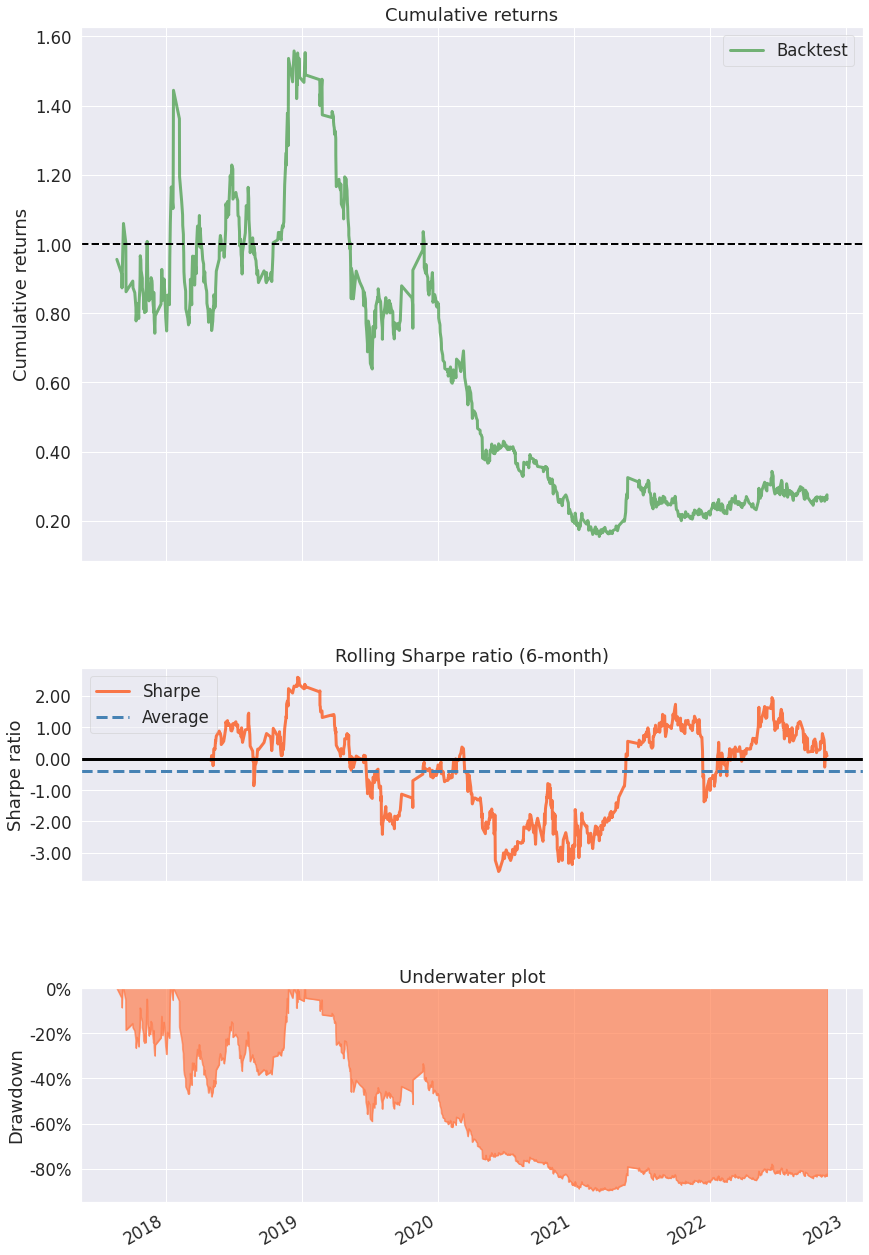

In [23]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [24]:
class CCIRawShortFilteredStrategy(Strategy):
    def init(self):
        super().init()
        self.sma_fast = resample_apply('30Min', SMA, self.data.Close, 50 )
        self.sma_slow = resample_apply('30Min', SMA, self.data.Close, 200)

    def next(self):
        super().next()

        is_down_trend   = False
        if self.sma_fast[-1]<self.sma_slow[-1]:
            is_down_trend = True

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==-1 and is_down_trend:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=1.0, sl=price_sl, tp=price_tp)

bt = Backtest(
    df, #df["2020-01-05":], 
    CCIRawShortFilteredStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2017-08-18 04:12:00
End                       2022-11-30 23:59:00
Duration                   1930 days 19:47:00
Exposure Time [%]                   44.169909
Equity Final [$]             100016688.178075
Equity Peak [$]              100022987.077609
Return [%]                           0.016688
Buy & Hold Return [%]               302.28287
Return (Ann.) [%]                    0.003154
Volatility (Ann.) [%]                0.011367
Sharpe Ratio                         0.277499
Sortino Ratio                        0.427909
Calmar Ratio                         0.165204
Max. Drawdown [%]                   -0.019093
Avg. Drawdown [%]                   -0.000356
Max. Drawdown Duration      543 days 04:28:00
Avg. Drawdown Duration        4 days 07:42:00
# Trades                                  623
Win Rate [%]                        33.707865
Best Trade [%]                      22.246537
Worst Trade [%]                    -14.032541
Avg. Trade [%]                    

Start date,2017-09-04
End date,2022-11-10
Total months,29
,Backtest
Annual return,-22.5%
Cumulative returns,-46.8%
Annual volatility,63.9%
Sharpe ratio,-0.09
Calmar ratio,-0.30
Stability,0.52
Max drawdown,-74.2%


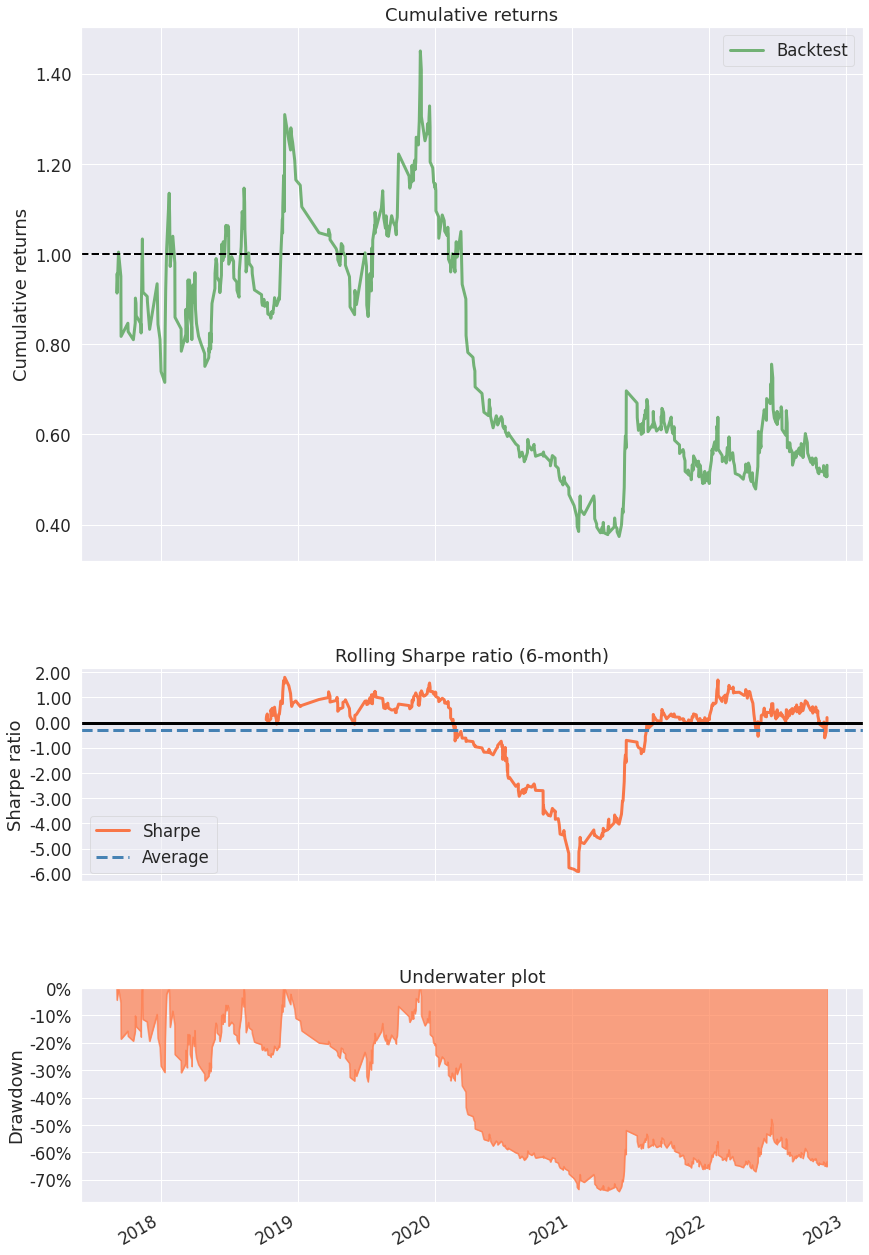

In [25]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [26]:
# TBL labeling training set 

RR         = 1.0
sl_target  = 1.2

min_ret    = 0.001 # minimum return of 0.1%

long_ptsl  = [round(sl_target*RR, 2), sl_target]
short_ptsl = [round(sl_target*RR, 2), sl_target]

print(f"{RR} -> {long_ptsl}")


long_triple_barrier_events = get_events( 
                                    close                  = df['Close'],
                                    t_events               = df[df['position']==1].index,
                                    pt_sl                  = long_ptsl,
                                    target                 = df['volatility_tpsl'],
                                    min_ret                = min_ret,
                                    num_threads            = 8,
                                    vertical_barrier_times = vertical_barriers,
                                    side                   = df[df['position']==1]['position']
                                    )

short_triple_barrier_events = get_events( 
                                    close                  = df['Close'],
                                    t_events               = df[df['position']==-1].index,
                                    pt_sl                  = short_ptsl,
                                    target                 = df['volatility_tpsl'],
                                    min_ret                = min_ret,
                                    num_threads            = 8,
                                    vertical_barrier_times = vertical_barriers,
                                    side                   = df[df['position']==-1]['position']
                                    )

triple_barrier_events = pd.concat([long_triple_barrier_events, short_triple_barrier_events])
triple_barrier_events = triple_barrier_events.sort_index()
triple_barrier_events.dropna(inplace=True)


labels = get_bins(triple_barrier_events, df['Close'])
labels.dropna(inplace=True)

labels = labels.sort_index()
labels = labels[~labels.index.duplicated(keep='last')]

labels['bin'].value_counts()

1.0 -> [1.2, 1.2]


2022-12-23 10:27:07.358589 100.0% apply_pt_sl_on_t1 done after 0.03 minutes. Remaining 0.0 minutes.
2022-12-23 10:27:09.488088 100.0% apply_pt_sl_on_t1 done after 0.03 minutes. Remaining 0.0 minutes.


0    4253
1    3828
Name: bin, dtype: int64

In [27]:
from mlfinlab.sample_weights import get_weights_by_return, get_weights_by_time_decay

return_based_sample_weights = get_weights_by_return(triple_barrier_events, df.loc[triple_barrier_events.index, 'Close'], num_threads=1)
return_based_sample_weights

2017-08-22 09:43:00    0.365822
2017-08-22 12:36:00    0.365822
2017-08-22 13:01:00    0.420782
2017-08-24 12:31:00    4.730772
2017-08-25 03:17:00    3.917484
                         ...   
2022-11-29 19:06:00    0.044049
2022-11-30 00:41:00    1.650334
2022-11-30 12:41:00    0.657023
2022-11-30 12:56:00    0.238043
2022-11-30 17:26:00    0.192940
Length: 8081, dtype: float64

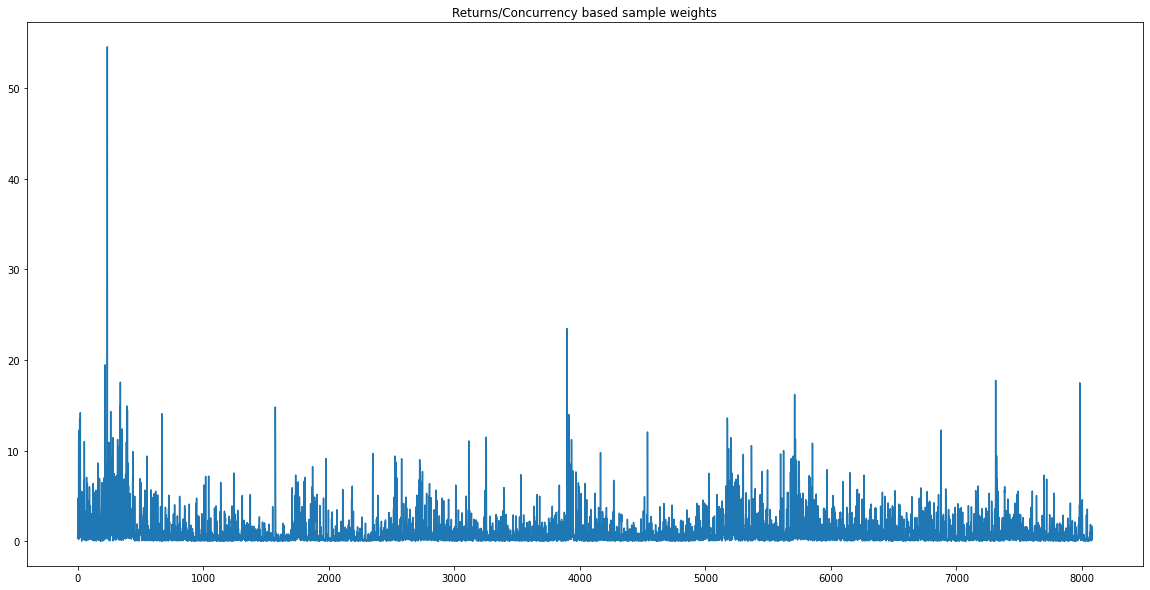

In [28]:
plt.figure(figsize=(20, 10))
plt.title('Returns/Concurrency based sample weights')
return_based_sample_weights.reset_index()[0].plot()
plt.show()

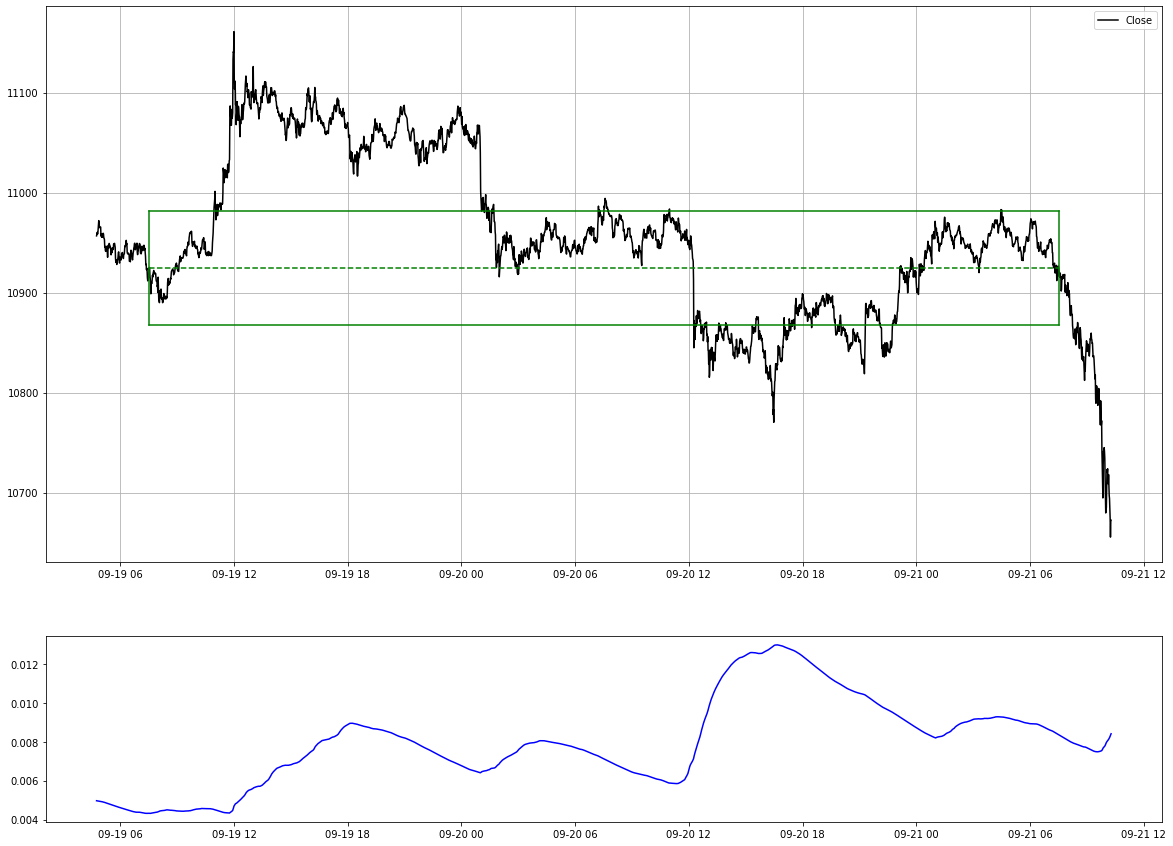

In [34]:
# Plotting buy side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = labels[(labels['bin']==1)&(labels['side']==1)].sample()
selected_date = label.index[0]

duration_seconds = 172800  # 2 days

frame_start   = selected_date - pd.Timedelta(seconds=10000) 
frame_end     = selected_date + pd.Timedelta(seconds=duration_seconds+10000)

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = selected_date
event_end   = selected_date+pd.Timedelta(seconds=duration_seconds)

close_price = df.loc[df.index==selected_date]['Close'].values[-1]

volatility_tpsl = round(df['volatility_tpsl'][selected_date], 6)

ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0

price_upper = (ret_upper+1.0)*close_price
price_lower = (ret_lower+1.0)*close_price

delta_upper = abs(close_price-price_upper)
delta_lower = abs(close_price-price_lower)

price_tp = close_price+delta_upper
price_sl = close_price-delta_lower


df_plot = df_

axs[0].plot(df_plot['Close'], color='k', label='Close')
axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_tp    , price_tp  ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [price_sl    , price_sl  ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='g')
axs[0].plot([event_start, event_start], [price_sl    , price_tp  ], 'r-' , color='g')
axs[0].plot([event_end  , event_end  ], [price_sl    , price_tp  ], 'r-' , color='g')

axs[1].plot(df_plot['volatility_tpsl'], color='b', label="daily volatility")

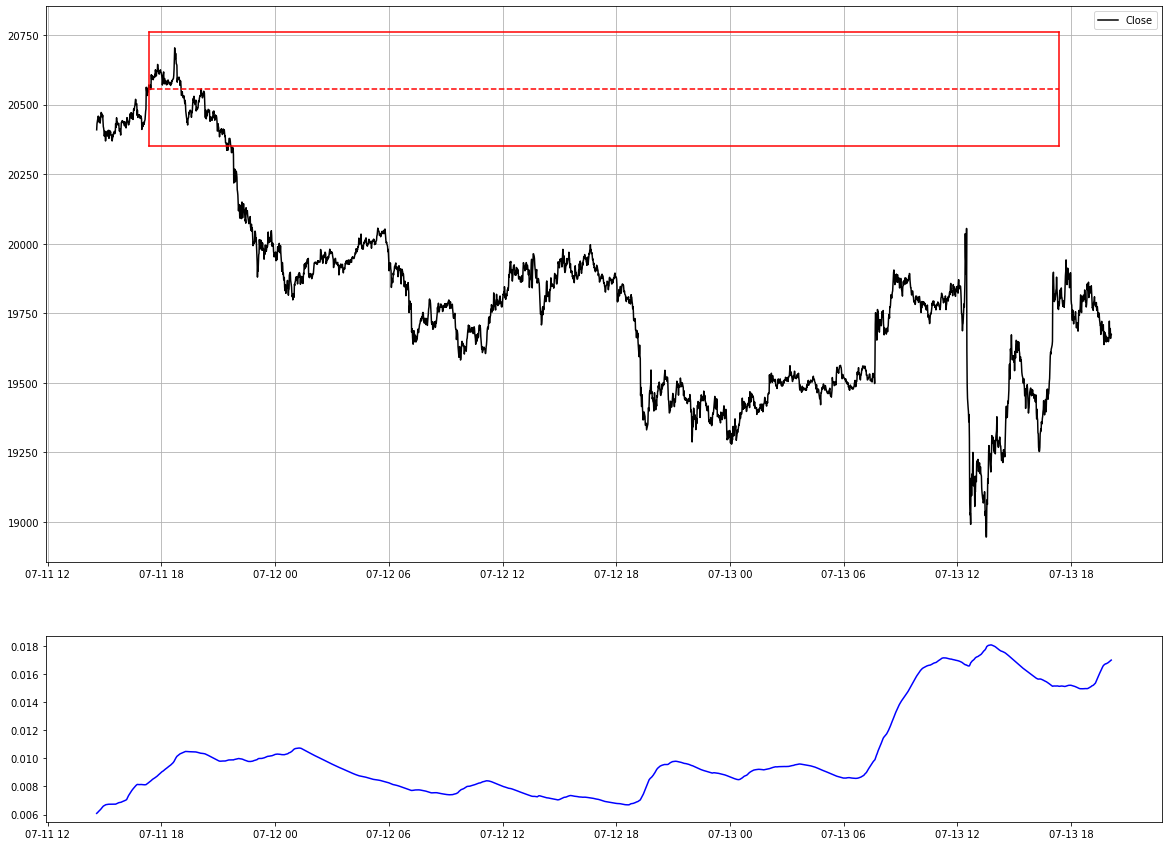

In [37]:
# Plotting sell side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = labels[(labels['bin']==1)&(labels['side']==-1)].sample()
selected_date = label.index[0]

duration_seconds = 172800 # 2 days

frame_start   = selected_date - pd.Timedelta(seconds=10000) 
frame_end     = selected_date + pd.Timedelta(seconds=duration_seconds+10000)

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = selected_date
event_end   = selected_date+pd.Timedelta(seconds=duration_seconds)

close_price = df.loc[df.index==selected_date]['Close'].values[-1]

volatility_tpsl = round(df['volatility_tpsl'][selected_date], 6)

ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0

price_upper = (ret_upper+1.0)*close_price
price_lower = (ret_lower+1.0)*close_price

delta_upper = abs(close_price-price_upper)
delta_lower = abs(close_price-price_lower)

price_sl = close_price+delta_upper
price_tp = close_price-delta_lower


df_plot = df_

axs[0].plot(df_plot['Close'], color='k', label='Close')
axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_tp    , price_tp  ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [price_sl    , price_sl  ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='r')
axs[0].plot([event_start, event_start], [price_sl    , price_tp  ], 'r-' , color='r')
axs[0].plot([event_end  , event_end  ], [price_sl    , price_tp  ], 'r-' , color='r')

axs[1].plot(df_plot['volatility_tpsl'], color='b', label="daily volatility")

In [38]:
# Model performance evaluation on OOS data
from backtesting     import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import resample_apply

def SMA(array, n):
    return pd.Series(array).rolling(n).mean()


binance_commission = 0.0004  # Taker Fee rate is 0.04%

In [39]:
class CCIRawLongStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==1:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=1.0, sl=price_sl, tp=price_tp)

bt = Backtest(
    df, #df["2020-01-05":], 
    CCIRawLongStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2017-08-18 04:12:00
End                       2022-11-30 23:59:00
Duration                   1930 days 19:47:00
Exposure Time [%]                   51.119623
Equity Final [$]             100011866.983034
Equity Peak [$]              100050363.425267
Return [%]                           0.011867
Buy & Hold Return [%]               302.28287
Return (Ann.) [%]                    0.002243
Volatility (Ann.) [%]                0.012824
Sharpe Ratio                         0.174905
Sortino Ratio                         0.24152
Calmar Ratio                         0.048266
Max. Drawdown [%]                   -0.046471
Avg. Drawdown [%]                   -0.000369
Max. Drawdown Duration      590 days 15:56:00
Avg. Drawdown Duration        2 days 15:21:00
# Trades                                 2078
Win Rate [%]                        50.529355
Best Trade [%]                       17.04008
Worst Trade [%]                    -13.822712
Avg. Trade [%]                    

Start date,2017-08-24
End date,2022-11-30
Total months,98
,Backtest
Annual return,6.5%
Cumulative returns,68.2%
Annual volatility,42.5%
Sharpe ratio,0.36
Calmar ratio,0.10
Stability,0.23
Max drawdown,-67.5%


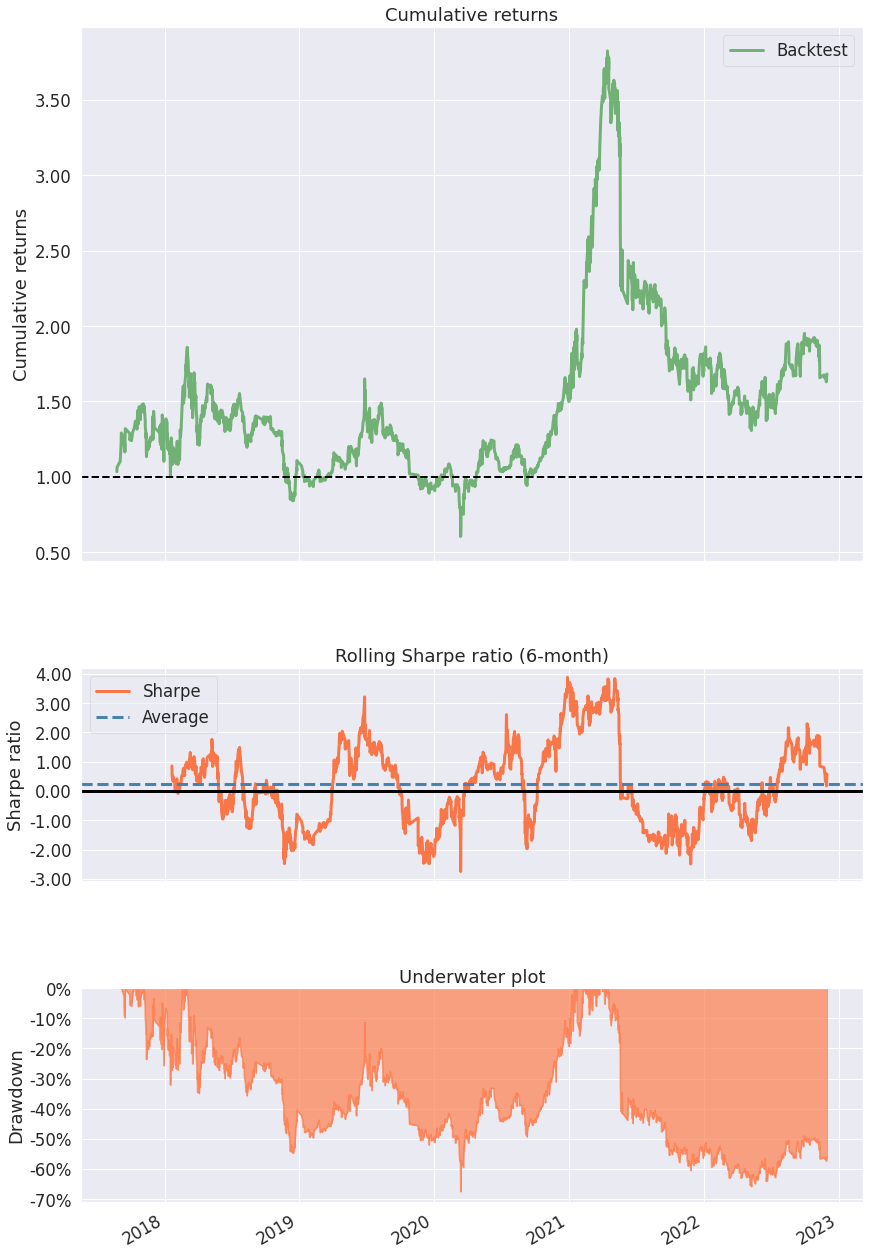

In [40]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [41]:
class CCIRawLongFilteredStrategy(Strategy):
    def init(self):
        super().init()
        self.sma_fast = resample_apply('30Min', SMA, self.data.Close, 50 )
        self.sma_slow = resample_apply('30Min', SMA, self.data.Close, 200)

    def next(self):
        super().next()

        is_up_trend   = False
        if self.sma_fast[-1]>self.sma_slow[-1]:
            is_up_trend = True

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==1 and is_up_trend:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=1.0, sl=price_sl, tp=price_tp)

bt = Backtest(
    df, #df["2020-01-05":], 
    CCIRawLongFilteredStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2017-08-18 04:12:00
End                       2022-11-30 23:59:00
Duration                   1930 days 19:47:00
Exposure Time [%]                   29.915501
Equity Final [$]              100016354.68929
Equity Peak [$]              100043025.279525
Return [%]                           0.016355
Buy & Hold Return [%]               302.28287
Return (Ann.) [%]                    0.003091
Volatility (Ann.) [%]                0.008384
Sharpe Ratio                         0.368719
Sortino Ratio                        0.523885
Calmar Ratio                         0.096472
Max. Drawdown [%]                   -0.032042
Avg. Drawdown [%]                     -0.0003
Max. Drawdown Duration      980 days 15:35:00
Avg. Drawdown Duration        2 days 16:42:00
# Trades                                 1185
Win Rate [%]                         51.64557
Best Trade [%]                      12.756121
Worst Trade [%]                    -12.147424
Avg. Trade [%]                    

Start date,2017-08-24
End date,2022-11-30
Total months,56
,Backtest
Annual return,28.1%
Cumulative returns,219.9%
Annual volatility,38.4%
Sharpe ratio,0.83
Calmar ratio,0.55
Stability,0.83
Max drawdown,-50.9%


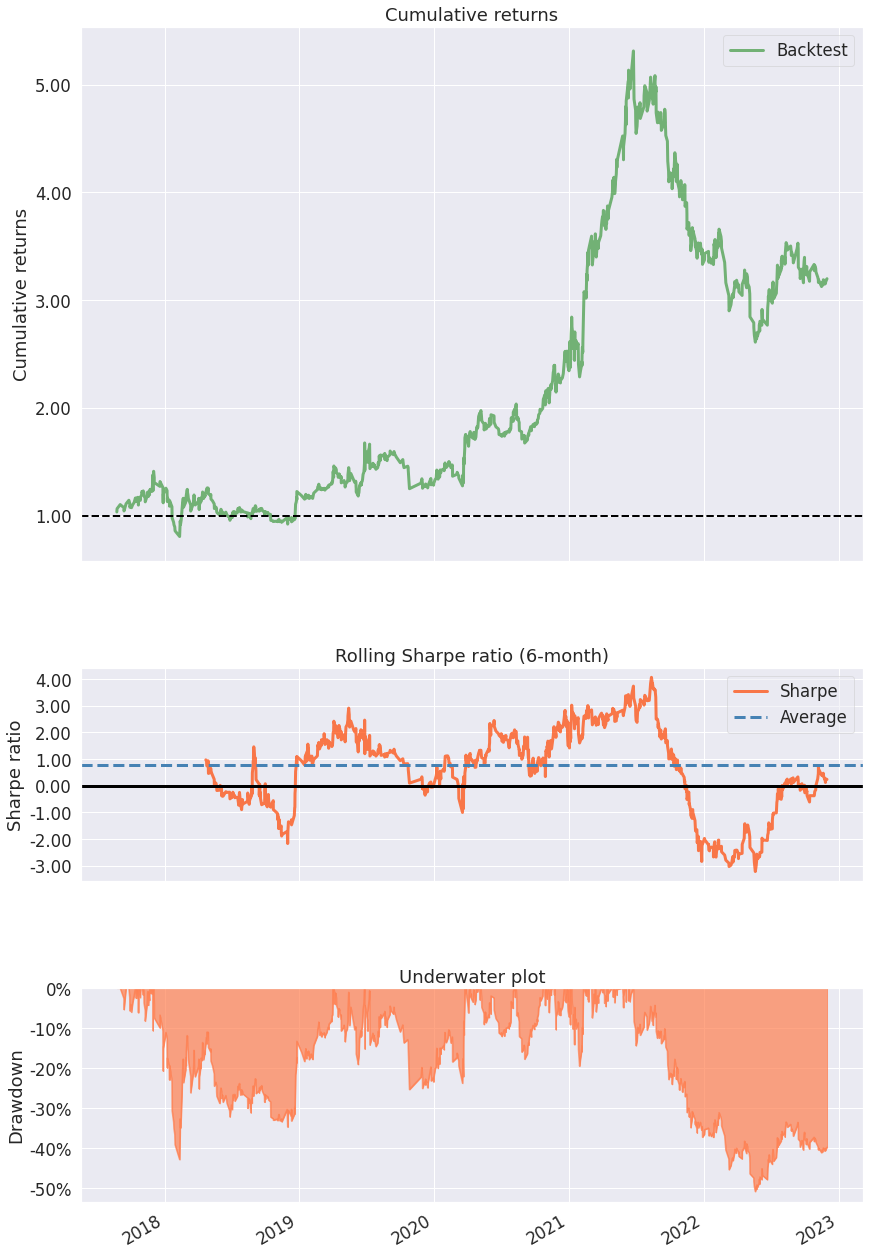

In [42]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [43]:
class CCIRawShortStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==-1:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=1.0, sl=price_sl, tp=price_tp)
    

bt = Backtest(
    df, #df["2020-01-05":], 
    CCIRawShortStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2017-08-18 04:12:00
End                       2022-11-30 23:59:00
Duration                   1930 days 19:47:00
Exposure Time [%]                   50.402191
Equity Final [$]             100030634.828773
Equity Peak [$]              100035770.630541
Return [%]                           0.030635
Buy & Hold Return [%]               302.28287
Return (Ann.) [%]                     0.00579
Volatility (Ann.) [%]                0.011143
Sharpe Ratio                         0.519594
Sortino Ratio                        0.786709
Calmar Ratio                         0.448732
Max. Drawdown [%]                   -0.012903
Avg. Drawdown [%]                   -0.000543
Max. Drawdown Duration      668 days 09:02:00
Avg. Drawdown Duration        6 days 03:24:00
# Trades                                 1879
Win Rate [%]                        48.962214
Best Trade [%]                      10.978802
Worst Trade [%]                    -14.032541
Avg. Trade [%]                    

Start date,2017-08-22
End date,2022-11-30
Total months,89
,Backtest
Annual return,-15.0%
Cumulative returns,-70.2%
Annual volatility,39.6%
Sharpe ratio,-0.21
Calmar ratio,-0.18
Stability,0.20
Max drawdown,-81.1%


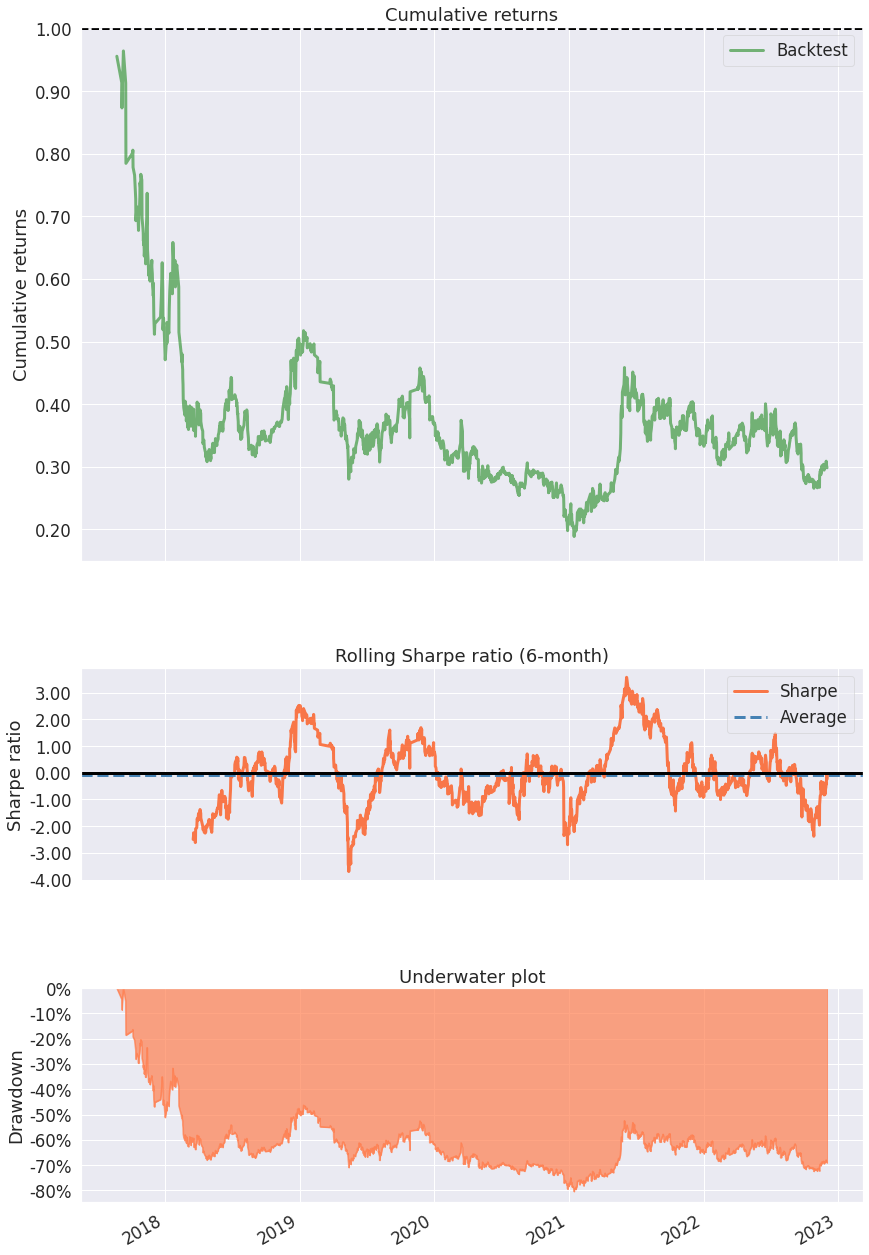

In [44]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [45]:
class CCIRawShortFilteredStrategy(Strategy):
    def init(self):
        super().init()
        self.sma_fast = resample_apply('30Min', SMA, self.data.Close, 50 )
        self.sma_slow = resample_apply('30Min', SMA, self.data.Close, 200)

    def next(self):
        super().next()

        is_down_trend   = False
        if self.sma_fast[-1]<self.sma_slow[-1]:
            is_down_trend = True

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==-1 and is_down_trend:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=1.0, sl=price_sl, tp=price_tp)

bt = Backtest(
    df, #df["2020-01-05":], 
    CCIRawShortFilteredStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2017-08-18 04:12:00
End                       2022-11-30 23:59:00
Duration                   1930 days 19:47:00
Exposure Time [%]                   28.111511
Equity Final [$]             100005511.663516
Equity Peak [$]              100016935.282522
Return [%]                           0.005512
Buy & Hold Return [%]               302.28287
Return (Ann.) [%]                    0.001042
Volatility (Ann.) [%]                0.008495
Sharpe Ratio                         0.122638
Sortino Ratio                        0.178382
Calmar Ratio                         0.057541
Max. Drawdown [%]                   -0.018105
Avg. Drawdown [%]                   -0.000325
Max. Drawdown Duration      554 days 07:11:00
Avg. Drawdown Duration        6 days 21:11:00
# Trades                                 1001
Win Rate [%]                         50.04995
Best Trade [%]                      10.978802
Worst Trade [%]                    -14.032541
Avg. Trade [%]                    

Start date,2017-09-04
End date,2022-11-30
Total months,47
,Backtest
Annual return,-13.4%
Cumulative returns,-43.6%
Annual volatility,41.1%
Sharpe ratio,-0.14
Calmar ratio,-0.26
Stability,0.10
Max drawdown,-52.5%


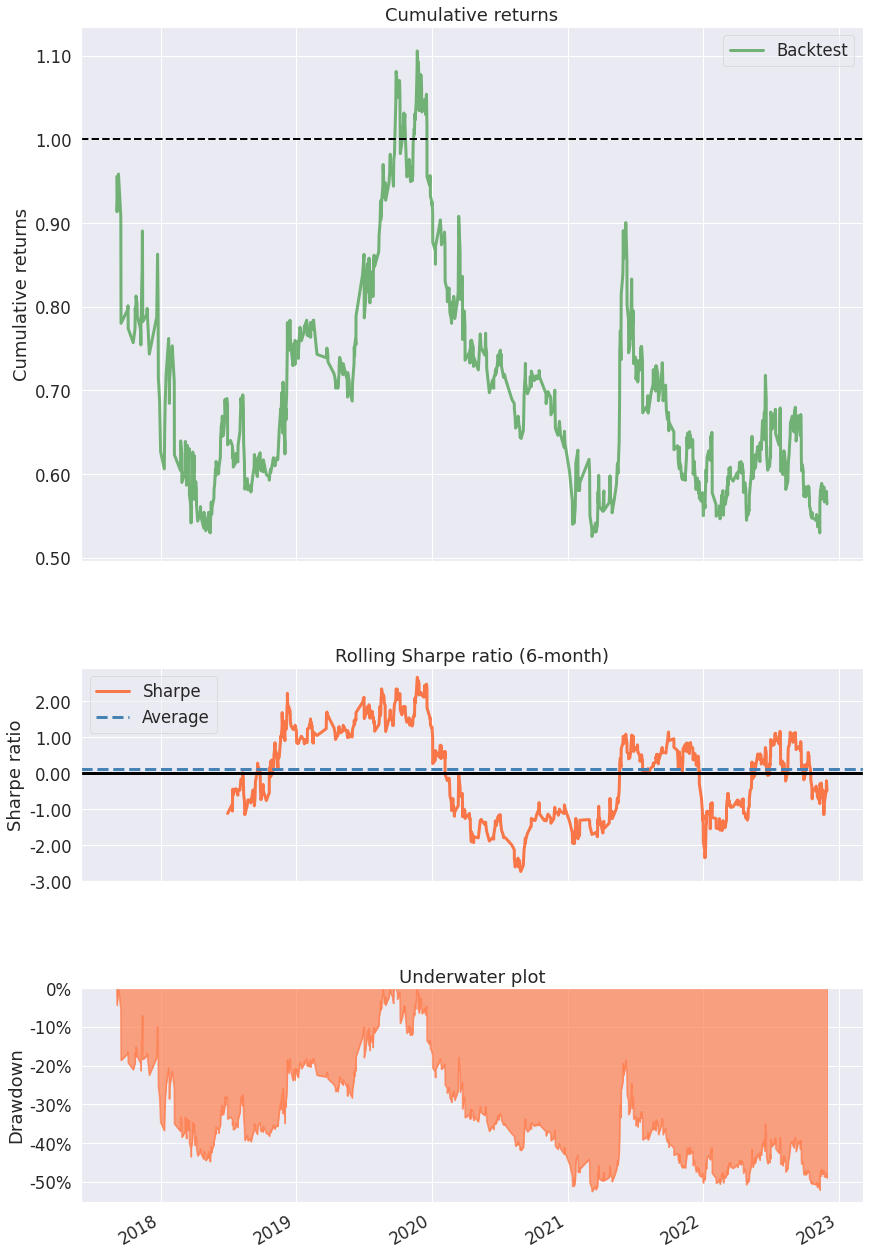

In [46]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [47]:
class CCIRawCombinedFilteredStrategy(Strategy):
    def init(self):
        super().init()
        self.sma_fast = resample_apply('30Min', SMA, self.data.Close, 50 )
        self.sma_slow = resample_apply('30Min', SMA, self.data.Close, 200)

    def next(self):
        super().next()

        is_down_trend = False
        is_up_trend   = False
        if self.sma_fast[-1]<self.sma_slow[-1]:
            is_down_trend = True
        if self.sma_fast[-1]>self.sma_slow[-1]:
            is_up_trend = True

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==1 and is_up_trend:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=1.0, sl=price_sl, tp=price_tp)

        if self.data.position[-1]==-1 and is_down_trend:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=1.0, sl=price_sl, tp=price_tp)

bt = Backtest(
    df,
    CCIRawCombinedFilteredStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2017-08-18 04:12:00
End                       2022-11-30 23:59:00
Duration                   1930 days 19:47:00
Exposure Time [%]                   51.539277
Equity Final [$]             100012856.351715
Equity Peak [$]              100047296.221231
Return [%]                           0.012856
Buy & Hold Return [%]               302.28287
Return (Ann.) [%]                     0.00243
Volatility (Ann.) [%]                0.011593
Sharpe Ratio                         0.209601
Sortino Ratio                        0.305778
Calmar Ratio                         0.056879
Max. Drawdown [%]                   -0.042723
Avg. Drawdown [%]                    -0.00046
Max. Drawdown Duration     1105 days 01:08:00
Avg. Drawdown Duration        4 days 09:34:00
# Trades                                 1918
Win Rate [%]                        50.521376
Best Trade [%]                      12.756121
Worst Trade [%]                    -14.032541
Avg. Trade [%]                    

Start date,2017-08-24
End date,2022-11-30
Total months,91
,Backtest
Annual return,-0.3%
Cumulative returns,-2.6%
Annual volatility,40.4%
Sharpe ratio,0.19
Calmar ratio,-0.01
Stability,0.37
Max drawdown,-66.7%


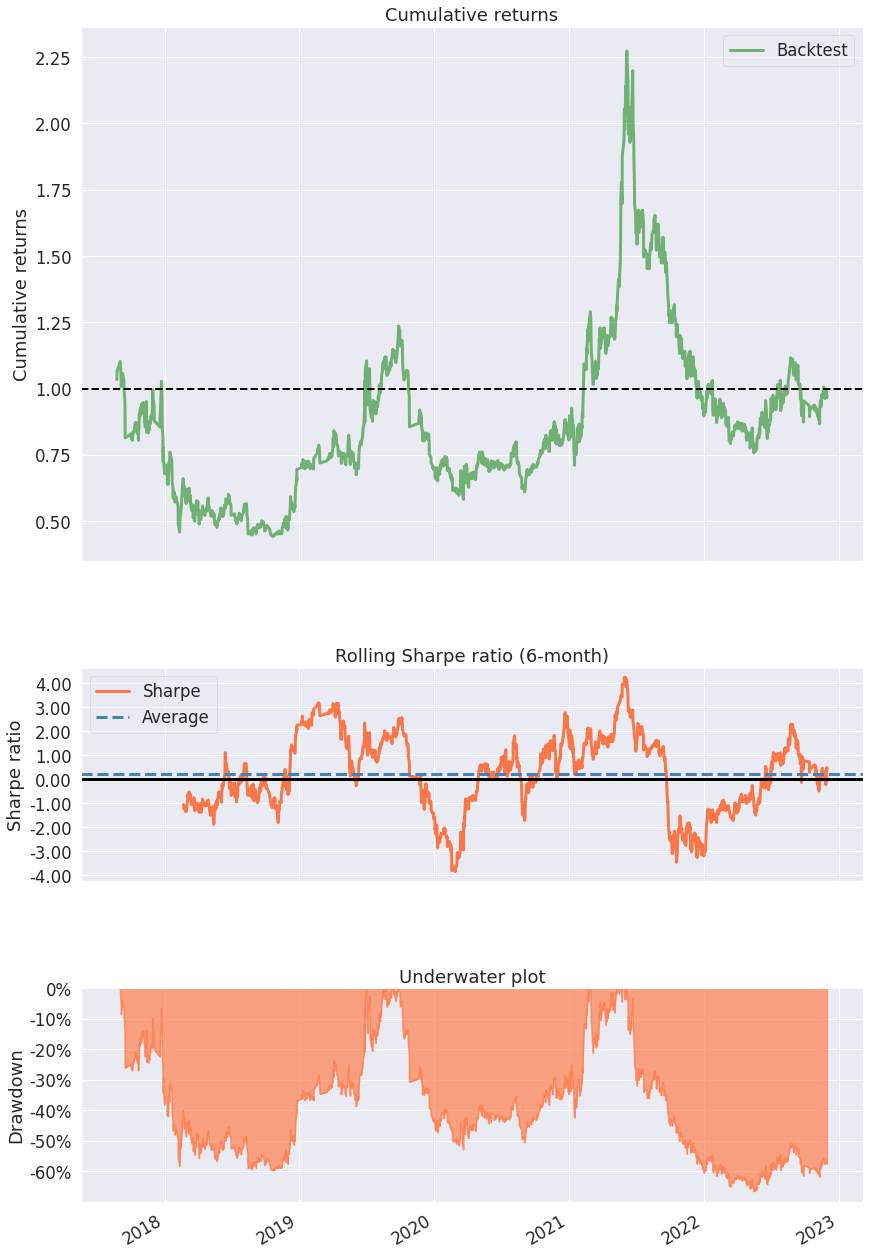

In [48]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [49]:
class CCIRawCombinedStrategy(Strategy):
    def init(self):
        super().init()

    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl[-1]

        if self.data.position[-1]==1:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=1.0, sl=price_sl, tp=price_tp)

        if self.data.position[-1]==-1:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=1.0, sl=price_sl, tp=price_tp)

bt = Backtest(
    df,
    CCIRawCombinedStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2017-08-18 04:12:00
End                       2022-11-30 23:59:00
Duration                   1930 days 19:47:00
Exposure Time [%]                   70.037653
Equity Final [$]             100044074.128253
Equity Peak [$]               100062576.58685
Return [%]                           0.044074
Buy & Hold Return [%]               302.28287
Return (Ann.) [%]                    0.008329
Volatility (Ann.) [%]                0.015035
Sharpe Ratio                         0.554005
Sortino Ratio                         0.85917
Calmar Ratio                         0.274056
Max. Drawdown [%]                   -0.030393
Avg. Drawdown [%]                   -0.000466
Max. Drawdown Duration     1241 days 23:52:00
Avg. Drawdown Duration        2 days 22:36:00
# Trades                                 2992
Win Rate [%]                        49.197861
Best Trade [%]                      12.756121
Worst Trade [%]                    -14.032541
Avg. Trade [%]                    

Start date,2017-08-22
End date,2022-11-30
Total months,142
,Backtest
Annual return,-11.6%
Cumulative returns,-76.9%
Annual volatility,40.2%
Sharpe ratio,-0.11
Calmar ratio,-0.12
Stability,0.06
Max drawdown,-94.4%


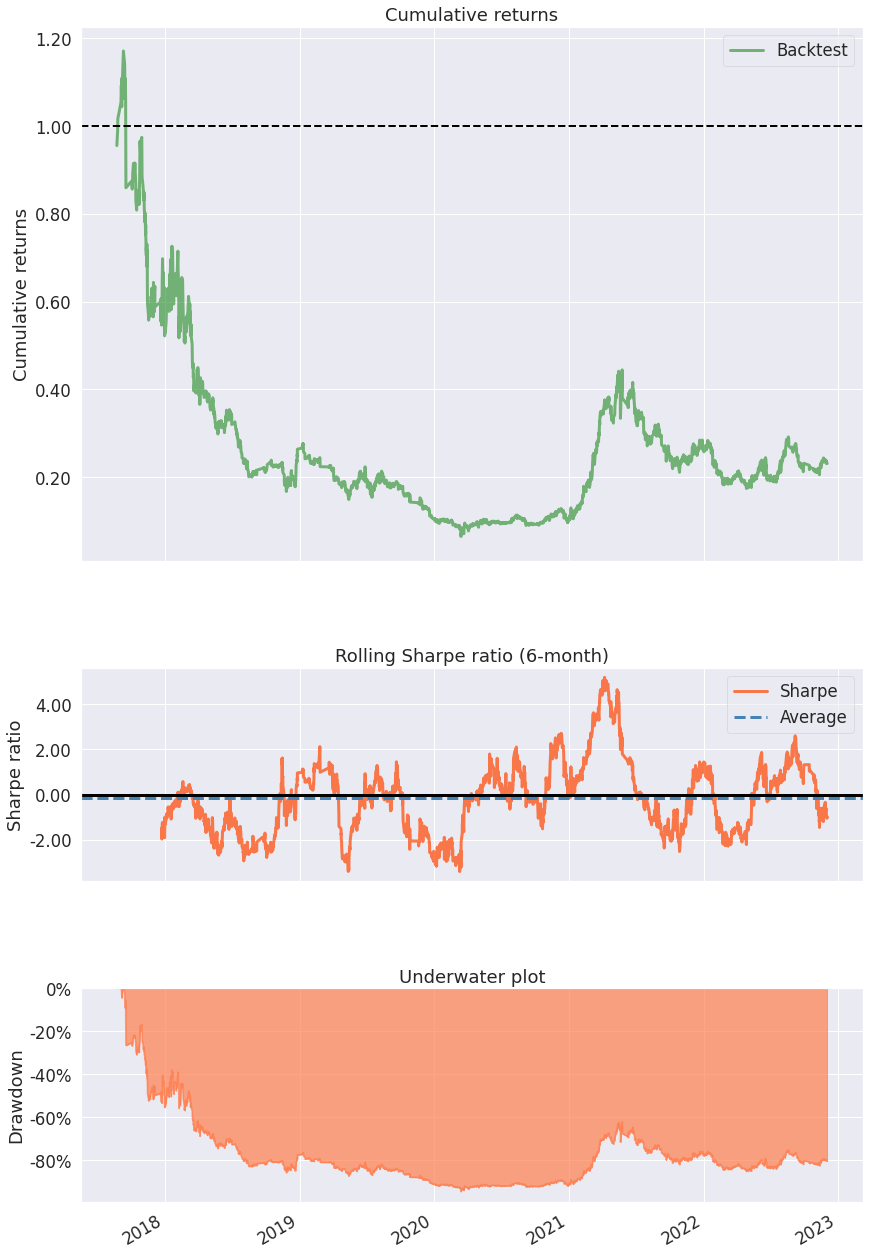

In [50]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])